In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

plt.style.use('dark_background')
dev = torch.device("mps" if 
                      torch.backends.mps.is_available() 
                      else "cpu")
print(f"Using device: {dev}")

Using device: mps


In [2]:
X, y = make_classification(
    n_samples=1000, n_features=20, 
    n_informative=10, n_classes=2, weights=[0.9, 0.1], 
    flip_y=0, random_state=47
)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=47)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=47)

In [3]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(dev)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(dev)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(dev)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(dev)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(dev)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(dev)
# Create DataLoader for training
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [4]:
# Define the simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(20, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize models for both loss functions
model_ce = SimpleNN().to(dev)
model_fl = SimpleNN().to(dev)

In [5]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2., alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    
    def forward(self, ins, tgs):
        # Calculate the Cross-Entropy Loss
        ce_loss = nn.CrossEntropyLoss(reduction='none')(ins, tgs)
        
        # Get probabilities from logits
        probs = torch.softmax(ins, dim=1)
        
        # Get probabilities for the true class labels
        probs_true_class = (
            probs[torch.arange(len(tgs)), tgs]
        )
        
        # Calculate focal weight for the true class
        focal_weight = (1 - probs_true_class) ** self.gamma
        
        # Apply alpha weighting
        alpha_factor = (
            self.alpha * tgs.float() + 
            (1 - self.alpha) * (1 - tgs).float()
        )
        # Calculate the focal loss
        focal_loss = alpha_factor * focal_weight * ce_loss
        
        # Return the average loss
        return focal_loss.mean()

In [6]:
cross_entropy_loss = nn.CrossEntropyLoss()
focal_loss = FocalLoss(alpha=0.9) # 0.9 (inv. prop. to pos. freq.)

In [7]:
def evaluate_model(model, X_data, y_data):
    model.eval()
    with torch.no_grad():
        outputs = model(X_data)
        _, predicted = torch.max(outputs, 1)
        return balanced_accuracy_score(
            y_true=y_data.cpu(), y_pred=predicted.cpu()
        )

In [8]:
def train_model(loss_fn, model, train_loader, X_val, y_val, 
                num_epochs=20, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    train_balanced_accuracies = []
    val_balanced_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(data)
            
            # Compute loss
            loss = loss_fn(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        # Compute balanced accuracy for train and validation sets
        train_accuracy = evaluate_model(model, X_train_tensor, 
                                        y_train_tensor)
        val_accuracy = evaluate_model(model, X_val, y_val)

        train_balanced_accuracies.append(train_accuracy)
        val_balanced_accuracies.append(val_accuracy)

    return train_balanced_accuracies, val_balanced_accuracies

# Train models with Cross-Entropy Loss and Focal Loss
print("Training with Cross-Entropy Loss")
epoch_train_acc_ce, epoch_val_acc_ce = train_model(
    cross_entropy_loss, model_ce, train_loader, 
    X_val_tensor, y_val_tensor, num_epochs=10
)

print("\nTraining with Focal Loss")
epoch_train_acc_fl, epoch_val_acc_fl = train_model(
    focal_loss, model_fl, train_loader, 
    X_val_tensor, y_val_tensor, num_epochs=10
)

Training with Cross-Entropy Loss

Training with Focal Loss


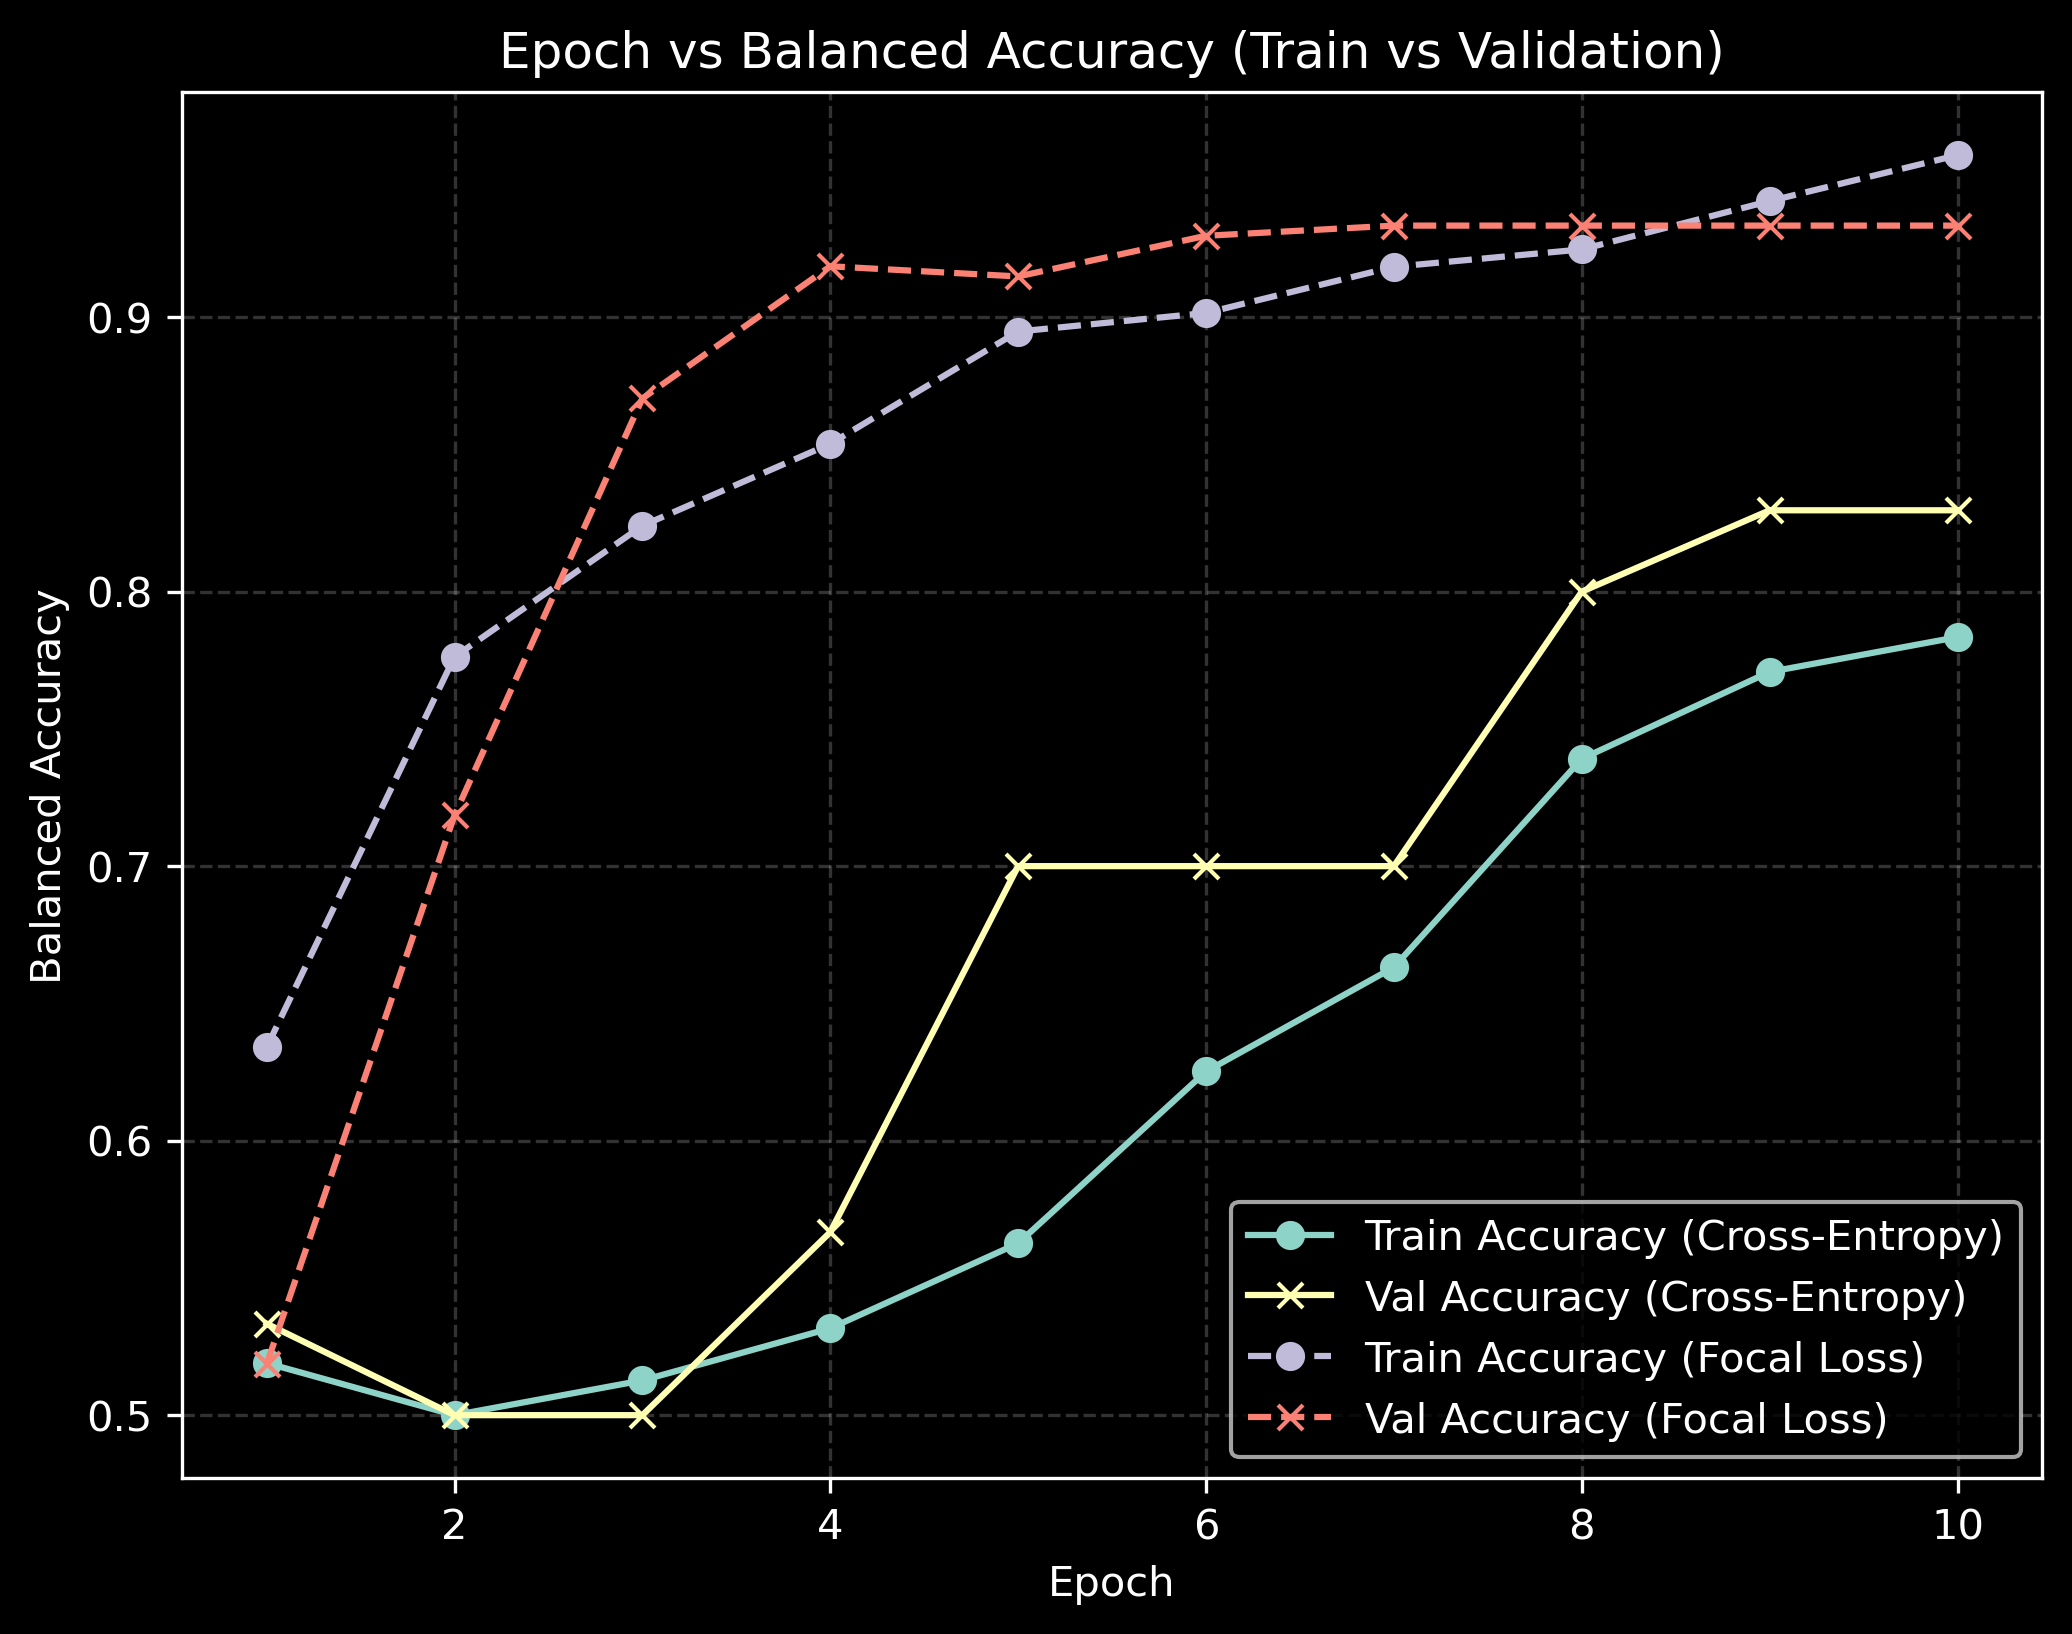


Test Balanced Accuracy (Cross-Entropy): 57.20%
Test Balanced Accuracy (Focal Loss): 85.98%


In [9]:
# Plot Balanced Accuracy over Epochs for both models
plt.figure(figsize=(8, 6), dpi=300)

# Cross-Entropy Loss plot
plt.plot(range(1, len(epoch_train_acc_ce) + 1), epoch_train_acc_ce, label='Train Accuracy (Cross-Entropy)', marker='o')
plt.plot(range(1, len(epoch_val_acc_ce) + 1), epoch_val_acc_ce, label='Val Accuracy (Cross-Entropy)', marker='x')

# Focal Loss plot
plt.plot(range(1, len(epoch_train_acc_fl) + 1), epoch_train_acc_fl, label='Train Accuracy (Focal Loss)', marker='o', linestyle='--')
plt.plot(range(1, len(epoch_val_acc_fl) + 1), epoch_val_acc_fl, label='Val Accuracy (Focal Loss)', marker='x', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Balanced Accuracy')
plt.title('Epoch vs Balanced Accuracy (Train vs Validation)')
plt.legend()
plt.grid(True, alpha=0.2, linestyle='--')
plt.show()

# Evaluate both models on the test set
test_acc_ce = evaluate_model(model_ce, X_test_tensor, y_test_tensor)
test_acc_fl = evaluate_model(model_fl, X_test_tensor, y_test_tensor)

print(f"\nTest Balanced Accuracy (Cross-Entropy): {test_acc_ce * 100:.2f}%")
print(f"Test Balanced Accuracy (Focal Loss): {test_acc_fl * 100:.2f}%")

### Focal Loss Definition

The **focal loss** for binary classification, considering class imbalance, is defined as:

$$
\text{FL}(p_t) = -\alpha_{t} (1 - p_t)^\gamma \log(p_t)
$$

Where:

- $p_t$ is the predicted probability for the true class $t$:
  $$
  p_t = 
  \begin{cases}
  p & \text{if } y = 1 \\
  1 - p & \text{if } y = 0
  \end{cases}
  $$

- $\alpha_{t}$ is the weighting factor for the positive class:
  - $\alpha$ is applied to the positive class ($y = 1$).
  - $1 - \alpha$ is applied to the negative class ($y = 0$).

- $(1 - p_t)^\gamma$ is the modulating factor, where $\gamma$ (the focusing parameter) reduces the loss for well-classified examples as $\gamma$ increases.
  - If $\gamma = 0$, this term has no effect, and the focal loss becomes equivalent to the **cross-entropy loss**.
  - As $\gamma$ increases, the loss for easy examples decreases more aggressively.


Reference:
**Lin, T.-Y., Goyal, P., Girshick, R., He, K., & Dollár, P.** (2017). Focal loss for dense object detection. *arXiv*. [https://arxiv.org/pdf/1708.02002](https://arxiv.org/pdf/1708.02002)
